## Final Project Submission

Please fill out:
* Student name: Kai Graham
* Student pace: self paced
* Scheduled project review date/time: 
* Instructor name: Jeff Herman
* Blog post URL:

In [1]:
# Your code here - remember to use markdown cells for comments as well!

## Scope:
In my evaluation of determining which movies do best at the box office, I wanted to focus on three main areas:
1. What length movies and genres / genre combinations tend to produce the most revenue / highest average rating?
2. How has domestic movie spend trended over time, and when is the best time during the year to release a movie?
3. Which writers should be targeted for hire to maximize chances of a high grossing movie?



## Process:
1. (Runtime & Genre Analysis) - Follow API instructions provided by themoviedb.org to register and generate API key and access code.  Use access code to authenticate API requests.  API results are limited to 20 results per page and 500 pages per request.  As a result, I had to split my request into smaller requests that could be returned by the API in entirety.  For this process, I decided to split each year into quarters.  For each year in the range 2000-2020, I make 4 api requests to pull in all movie data and append to a dataframe.  After all API requests are made, additional movie details are needed to pull in information on runtime and genres.  For each movie ID in my existing dataframe, I make another API call to pull in movie details associated with that ID.  Once all additional detail is pulled in, I clean data, handle missing values, replace placeholders where necessary, and evaluate the relationship between runtime and revenue.  After runtime, I move on to genres, looking at highest grossing movies on a total and median basis.  I perform the same thing for total and median average vote as well to compare differences between rating and revenue. 
2. (Domestic Spend Trends) - Use BeautifulSoup to scrape domestic box office spend data from boxofficemojo.com.  Once data is loaded, create scatter plots of annual and monthly revenue over time to show trends.  After this, I group the data by month to show the distribution of gross domestic spend in each month for all years.  Given the difference in variance between different months, I also decided to create a boxplot of gross domestic spend for all months.
3. (Writers) - load provided datasets from IMDB.  Multiple writers can be included for each movie.  In these instances, I created a row for each individual writer.  Once I expanded writers onto new rows, I joined writer names from a provided imdb dataset and revenue from the API call to themoviedb.org performed for question 1.  Once all data was loaded, I grouped by writer name to calculate median aggregate statistics. Sort revenue column descending and produce bar charts.

## Question 1: What length movies and genres / genre combinations tend to produce the most revenue / highest average ratings?

### Movie Runtime Analysis
Outline:
1. Import necessary libraries
2. Create function to build progress bar to keep track of running calculations
3. Pull in API / Access Keys and request from TMDB API a list of movie IDs from 2000 through 2020
4. Create function to check how many pages of requests are returned by the API
5. Create function to loop through all returned pages to extract movie IDs and other information
6. Create a dataframe using returned movie IDs
7. Clean data (handle missing data, duplicates, data that does not make sense in the context of this analysis)
8. Request movie details via API for every movie ID we have from our first set of API requests
9. Split dataset into different buckets based on movie runtime and analyze differences in revenue / ratings
10. Create Visualizations

In [2]:
#import necessary libraries
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import json
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

Given length of calculations when calling API, I wanted a way to show status of calculations.  I followed the step-by-step instructions laid out by Bartosz Mikulski here: https://www.mikulskibartosz.name/how-to-display-a-progress-bar-in-jupyter-notebook/

In [3]:
import time, sys
from IPython.display import clear_output

def update_progress(progress):
    """
    Function to build progress bar.
    Function returns percent of calculations remaining along with visual of progress completed so far.
    For use in loops.
    """
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1
        
    block = int(round(bar_length * progress))
    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text) 

In [4]:
def get_keys(path):
    """
    Takes a filepath as input and returns the keys of the dictionary within the file
    """
    with open(path) as f:
        return json.load(f)

API instructions found here: 'https://developers.themoviedb.org/3/getting-started/introduction'
 * Register for API key
 * Enter API key on website to generate access token
 * Create necessary headers using access token

In [5]:
#Use get_keys() function to pull in specific API keys and access token 
keys = get_keys('/Users/addingtongraham/.secret/tmdb_api.json')
api_key = keys['api_key']
access_token = keys['access_token']

In [6]:
#Use generated API Key and Access Token in headers to authorize access and API requests
headers = {'Authorization': 'Bearer {}'.format(access_token)
          ,'Content-Type': 'application/json;charset=utf-8'}

In [7]:
def get_num_pages(url, headers, start_date, end_date):
    """
    Takes as input an API url, headers containing authentication information, a start date, and end date.
    Returns the number of pages of results returned by the API call as an int. 
    """
    params = {'release_date.gte': start_date,
              'release_date.lte': end_date}
    returned_movies = requests.get(url=url, headers=headers, params=params).json()
    return returned_movies['total_pages']

Data returned by API call is limited to 20 results per page, and a maximum of 500 pages.  Because the number of results is limited, it is not possible to pull movie data from 2000 through 2020 in one request.  As a result, each year is split into quarters.  Request quarterly data via API and append to consolidated dataframe

In [8]:
def get_movies_data(start_date, end_date, url, headers):
    """
    Takes a start date, end date, API url, and headers with authentication information.
    Uses get_num_pages function to check the number of pages returned by the API.
    Loops through all pages, requesting data from API, concatenating results to a dataframe.
    Returns dataframe of movie information between start and end date.
    """
    df = pd.DataFrame()
    num_pages = get_num_pages(url, headers, start_date, end_date)
    for i in range(1, num_pages+1):
        parameters = {'primary_release_date.gte': start_date,
                      'primary_release_data.lte': end_date,
                      'page': i}
        request = requests.get(url, headers=headers, params=parameters).json()
        df = pd.concat([df, pd.DataFrame(request['results'])], sort=False)
        
    return df

The API request takes a fair amount of time to run through completion.  To validate the function works as intended, the below code is used to test the function.

In [9]:
#test to make sure function worked
df = get_movies_data(start_date='2020-01-01',
                     end_date='2020-01-31',
                     url='https://api.themoviedb.org/3/discover/movie',
                     headers=headers)

In [10]:
#check info
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2100 entries, 0 to 19
Data columns (total 14 columns):
popularity           2100 non-null float64
vote_count           2100 non-null int64
video                2100 non-null bool
poster_path          1728 non-null object
id                   2100 non-null int64
adult                2100 non-null bool
backdrop_path        1175 non-null object
original_language    2100 non-null object
original_title       2100 non-null object
genre_ids            2100 non-null object
title                2100 non-null object
vote_average         2100 non-null float64
overview             2100 non-null object
release_date         2100 non-null object
dtypes: bool(2), float64(2), int64(2), object(8)
memory usage: 217.4+ KB


The test works as intended.  Given API limitations, it is not possible to pull in a full year of movie data at once.  As a result, one year of data is pulled in via 4 API calls (one for each quarter of the year).  Create functions to generate a list of start and end dates to loop through and call `get_movies_data`

In [11]:
def create_quarter_date_list(year):
    """
    Returns a list of quarterly start dates and a list of quarterly end dates from int input representing year.
    """
    start_dates = [f'{year}-01-01', f'{year}-04-01', f'{year}-07-01', f'{year}-10-01']
    end_dates = [f'{year}-03-31', f'{year}-06-30', f'{year}-09-30', f'{year}-12-31']
    return start_dates, end_dates

In [12]:
#create start and end dates for 2000 to 2020
start_dates = []
end_dates = []
for year in range(2000, 2021):
    start_date, end_date = create_quarter_date_list(year)
    start_dates += start_date
    end_dates += end_date

In [13]:
#get movie data and concat to current dataframe
df = pd.DataFrame()
url = 'https://api.themoviedb.org/3/discover/movie'

#loop through all start and end dates and make an API call for each date range
#append results to df
for i, start_date in enumerate(start_dates):
    temp_df = get_movies_data(start_date=start_date, end_date=end_dates[i], url=url, headers=headers)
    df = pd.concat([df, temp_df], sort=False)
    
    update_progress(i / (len(start_dates)-1))

Progress: [####################] 100.0%


In [14]:
#check the requests worked
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 326586 entries, 0 to 19
Data columns (total 14 columns):
popularity           326586 non-null float64
vote_count           326586 non-null int64
video                326586 non-null bool
poster_path          317326 non-null object
id                   326586 non-null int64
adult                326586 non-null bool
backdrop_path        287277 non-null object
original_language    326586 non-null object
original_title       326586 non-null object
genre_ids            326586 non-null object
title                326586 non-null object
vote_average         326586 non-null float64
overview             326586 non-null object
release_date         326586 non-null object
dtypes: bool(2), float64(2), int64(2), object(8)
memory usage: 33.0+ MB


In [15]:
#given long runtime create a copy of the df
movies = df.copy()

Begin initial cleaning of data.

In [16]:
#remove movies with release dates after 5/22/2020
#not interested in release dates of movies in the future
movies = movies.loc[movies['release_date'] <= '2020-05-22']

In [17]:
#check for duplicate IDs
movies['id'].duplicated().sum()

283816

In [18]:
#drop duplicate IDs
movies.drop_duplicates(subset='id', inplace=True)

In [19]:
#check how many rows remain
len(movies)

22526

In [20]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22526 entries, 0 to 18
Data columns (total 14 columns):
popularity           22526 non-null float64
vote_count           22526 non-null int64
video                22526 non-null bool
poster_path          21587 non-null object
id                   22526 non-null int64
adult                22526 non-null bool
backdrop_path        16527 non-null object
original_language    22526 non-null object
original_title       22526 non-null object
genre_ids            22526 non-null object
title                22526 non-null object
vote_average         22526 non-null float64
overview             22526 non-null object
release_date         22526 non-null object
dtypes: bool(2), float64(2), int64(2), object(8)
memory usage: 2.3+ MB


In [21]:
#remove irrelevant columns
movies = movies.drop(columns=['poster_path', 'backdrop_path'])

`poster_path` and `backdrop_path` are filepaths / urls to the posters and backdrops of each movie. These are not relevant for analysis, so can be removed. 

In [22]:
#check for NaNs
movies.isna().sum()

popularity           0
vote_count           0
video                0
id                   0
adult                0
original_language    0
original_title       0
genre_ids            0
title                0
vote_average         0
overview             0
release_date         0
dtype: int64

There are no remaining missing values or duplicate IDs.
Loop through all movie IDs and make additional API requests using the proper API URL (listed below) to pull in additional movie details for each movie ID.

In [23]:
movie_details = [] #blank list to store data from API

#set url and headers
url = 'https://api.themoviedb.org/3/movie'
headers = {'Authorization': 'Bearer {}'.format(access_token),
           'Content-Type': 'application/json;charset=utf-8'}

#loop through all movie IDs, request details, and append to movie_details
for index, movie_id in enumerate(movies['id']):
    response = requests.get(f'{url}/{movie_id}', headers=headers).json()
    movie_details.append(response)
    update_progress(index / len(movies['id']))

Progress: [####################] 100.0%


In [24]:
#create dataframe from list
movies_df = pd.DataFrame(movie_details)

In [25]:
#examine the dataframe
movies_df.head()

,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,...,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,status_code,status_message
0,False,/5BwqwxMEjeFtdknRV792Svo0K1v.jpg,None,87500000.0,"[{'id': 878, 'name': 'Science Fiction'}, {'id'...",https://www.foxmovies.com/movies/ad-astra,419704.0,tt2935510,en,Ad Astra,...,123.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,The answers we seek are just outside our reach,Ad Astra,False,6.0,3514.0,NaN,NaN
1,False,/ocUrMYbdjknu2TwzMHKT9PBBQRw.jpg,None,42000000.0,"[{'id': 28, 'name': 'Action'}, {'id': 878, 'na...",https://www.bloodshot.movie/,338762.0,tt1634106,en,Bloodshot,...,110.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Being a superhero is in his blood,Bloodshot,False,7.1,2407.0,NaN,NaN
2,False,/fKtYXUhX5fxMxzQfyUcQW9Shik6.jpg,None,0.0,"[{'id': 10751, 'name': 'Family'}, {'id': 16, '...",https://www.scoob.movie/,385103.0,tt3152592,en,Scoob!,...,94.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Mystery loves company.,Scoob!,False,8.0,731.0,NaN,NaN
3,False,/1EGFjibWzsN2GNNeOSQBYhQ9pK5.jpg,None,0.0,"[{'id': 28, 'name': 'Action'}, {'id': 35, 'nam...",https://www.netflix.com/title/81248748,576156.0,tt8851668,en,The Lovebirds,...,86.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,All they wanted was a quiet night out,The Lovebirds,False,6.5,120.0,NaN,NaN
4,False,/pPguXG07MDRKH1agJdw1mWzuEkP.jpg,None,0.0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",,686245.0,tt10303324,en,Survive the Night,...,89.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,,Survive the Night,False,5.7,62.0,NaN,NaN


In [26]:
#remove the status_code and status_message columns
movies_df = movies_df.drop(columns=['status_code', 'status_message'])

In [27]:
#check for duplicates in the id column
movies_df['id'].duplicated().sum()

4

In [28]:
#remove duplicates
movies_df['id'].drop_duplicates(inplace=True)

In [29]:
#check that it worked
movies_df['id'].duplicated().sum()

0

In [30]:
#check for missing values
movies_df.isna().sum()

adult                        5
backdrop_path             6002
belongs_to_collection    20404
budget                       5
genres                       5
homepage                  2920
id                           5
imdb_id                   3101
original_language            5
original_title               5
overview                     5
popularity                   5
poster_path                941
production_companies         5
production_countries         5
release_date                 5
revenue                      5
runtime                    594
spoken_languages             5
status                       5
tagline                      5
title                        5
video                        5
vote_average                 5
vote_count                   5
dtype: int64

In [31]:
#there are a number of irrelevant columns we can remove
movies_df = movies_df.drop(columns=['backdrop_path', 'belongs_to_collection',
                        'homepage', 'poster_path'])

In [32]:
#recheck for missing values
movies_df.isna().sum()

adult                      5
budget                     5
genres                     5
id                         5
imdb_id                 3101
original_language          5
original_title             5
overview                   5
popularity                 5
production_companies       5
production_countries       5
release_date               5
revenue                    5
runtime                  594
spoken_languages           5
status                     5
tagline                    5
title                      5
video                      5
vote_average               5
vote_count                 5
dtype: int64

In [33]:
#examine the rows that seem to be missing data
movies_df.loc[movies_df['adult'].isna()]

,adult,budget,genres,id,imdb_id,original_language,original_title,overview,popularity,production_companies,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
2784,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12124,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15279,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17812,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
#we can remove all these rows as they contain no data
movies_df = movies_df.dropna(subset=['adult'])

Copy dataframe to run runtime-specific analyses

In [35]:
runtime_df = movies_df.copy()

In [36]:
#recheck for missing values
runtime_df.isna().sum()

adult                      0
budget                     0
genres                     0
id                         0
imdb_id                 3096
original_language          0
original_title             0
overview                   0
popularity                 0
production_companies       0
production_countries       0
release_date               0
revenue                    0
runtime                  589
spoken_languages           0
status                     0
tagline                    0
title                      0
video                      0
vote_average               0
vote_count                 0
dtype: int64

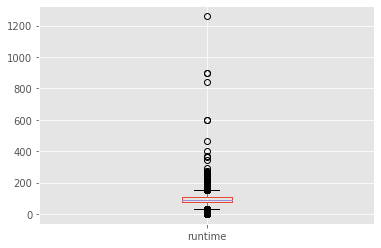

In [37]:
#check distribution of runtime using boxplot
runtime_df['runtime'].plot.box()

In [38]:
#display summary statistics 
runtime_df['runtime'].describe()

count    21932.000000
mean        82.217946
std         42.623435
min          0.000000
25%         75.000000
50%         90.000000
75%        105.000000
max       1260.000000
Name: runtime, dtype: float64

Reviewing the boxplot and summary statistics, we see that median movie runtime is 90 minutes, with a standard deviation of 42 minutes.  Given the shape of the boxplot, we can see there is a clear positive skew.  There are also a number of outliers we can see in the boxplot, including one movie with a max runtime of 1260 minutes (21 hours), and movies with runtimes of 0.  Given potential influence of runtime outliers, we will focus on the median vs. mean. 

In [39]:
#there is a significant outlier
runtime_df['runtime'].max()

1260.0

In [40]:
#looking this movie up - - it was an experimental movie, so will remove it for analysis
runtime_df = runtime_df.loc[runtime_df['runtime'] < runtime_df['runtime'].max()]

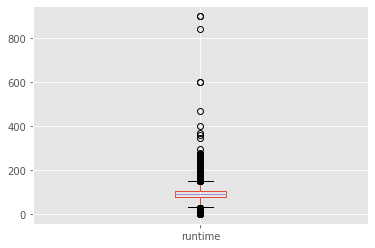

In [41]:
#recheck box plot
runtime_df['runtime'].plot.box()

In [42]:
#check summary stats
runtime_df['runtime'].describe()

count    21931.000000
mean        82.164242
std         41.875801
min          0.000000
25%         75.000000
50%         90.000000
75%        105.000000
max        900.000000
Name: runtime, dtype: float64

The distribution does not look drastically different, with median runtime still at 90 minutes.  The majority of movies have runtimes between 75 minutes and 105 minutes. 

In [43]:
#check what proportion of total runtimes are 0
runtime_df['runtime'].value_counts()

0.0      1623
90.0     1301
95.0      539
100.0     523
85.0      514
         ... 
218.0       1
254.0       1
226.0       1
227.0       1
214.0       1
Name: runtime, Length: 241, dtype: int64

A movie with a runtime of 0 does not make conceptual sense, so cases where this exists must represent placeholder or missing information.  Check what percentage of all entries have a runtime of 0.

In [44]:
#0 runtimes represent ~8% of the data - - replace with median
runtime_df['runtime'] = runtime_df['runtime'].replace(0.0, runtime_df['runtime'].median())

In [45]:
#check it worked
runtime_df['runtime'].value_counts()

90.0     2924
95.0      539
100.0     523
85.0      514
84.0      468
         ... 
227.0       1
201.0       1
369.0       1
233.0       1
263.0       1
Name: runtime, Length: 240, dtype: int64

In [46]:
#there are number of outliers, but I have decided to not remove them as they may
#inform performance of longer runtime movies, even though the majority are centered around 90 minutes
runtime_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21931 entries, 0 to 22525
Data columns (total 21 columns):
adult                   21931 non-null object
budget                  21931 non-null float64
genres                  21931 non-null object
id                      21931 non-null float64
imdb_id                 19000 non-null object
original_language       21931 non-null object
original_title          21931 non-null object
overview                21931 non-null object
popularity              21931 non-null float64
production_companies    21931 non-null object
production_countries    21931 non-null object
release_date            21931 non-null object
revenue                 21931 non-null float64
runtime                 21931 non-null float64
spoken_languages        21931 non-null object
status                  21931 non-null object
tagline                 21931 non-null object
title                   21931 non-null object
video                   21931 non-null object
vote_average

In [47]:
#check how many movies in our runtime df have revenue of 0
runtime_df['revenue'].value_counts()

0.0            17794
4100000.0          5
2000000.0          5
1000000.0          4
102000000.0        3
               ...  
90810892.0         1
709452.0           1
12923936.0         1
43306325.0         1
2063312.0          1
Name: revenue, Length: 4074, dtype: int64

~80% of our dataset contains revenue of 0.  While it is possible that a movie does so poorly that it generates 0 revenue, it is more likely that these datapoints are missing revenue information.  As we are more concerned with those movies that generate positive revenue, I have chosen to only examing movies that contain positive runtimes

In [48]:
#we are concerned with movies that generate positive revenue
#so will remove all 0 revenue movies
runtime_df = runtime_df.loc[runtime_df['revenue'] > 0]

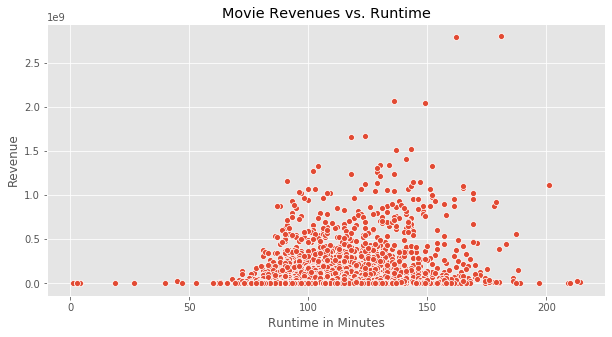

In [49]:
#plot revenue vs. runtime to evaluate relationship between the two
plt.figure(figsize=(10, 5))
sns.scatterplot(x='runtime', y='revenue', data=runtime_df)
plt.title('Movie Revenues vs. Runtime')
plt.xlabel('Runtime in Minutes')
plt.ylabel('Revenue')
plt.show()

From the graphic above, the highest grossing movies tend to have runtimes that fall between 2 and 3 hours.
There seem to be diminishing returns to increasing runtime above 3 hours

In [50]:
#create dataframes to evaluate data at different length movies
movies_lt_30 = runtime_df.loc[runtime_df['runtime'] <= 30]
movies_lt_60 = runtime_df.loc[(runtime_df['runtime'] > 30) &
                              (runtime_df['runtime'] <= 60)]
movies_lt_90 = runtime_df.loc[(runtime_df['runtime'] > 60) &
                              (runtime_df['runtime'] <= 90)]
movies_lt_120 = runtime_df.loc[(runtime_df['runtime'] > 90) &
                               (runtime_df['runtime'] <= 120)]
movies_lt_150 = runtime_df.loc[(runtime_df['runtime'] > 120) &
                               (runtime_df['runtime'] <= 150)]
movies_lt_180 = runtime_df.loc[(runtime_df['runtime'] > 150) &
                               (runtime_df['runtime'] <= 180)]
movies_gt_180 = runtime_df.loc[(runtime_df['runtime'] > 180)]

In [51]:
#look at medians for each
sub_30_median = movies_lt_30['revenue'].median()
sub_60_median = movies_lt_60['revenue'].median()
sub_90_median = movies_lt_90['revenue'].median()
sub_120_median = movies_lt_120['revenue'].median()
sub_150_median = movies_lt_150['revenue'].median()
sub_180_median = movies_lt_180['revenue'].median()
gt_180_median = movies_gt_180['revenue'].median()

In [52]:
#print medians
print(f'Sub 30 Minute Movies Median Revenue: ${round(sub_30_median/1000000, 5)} million')
print(f'30-60 Minute Movies Median Revenue: ${round(sub_60_median / 1000000, 5)} million')
print(f'60-90 Minute Movies Median Revenue: ${round(sub_90_median/1000000, 2)} million')
print(f'90-120 Minute Movies Median Revenue: ${round(sub_120_median/1000000, 2)} million')
print(f'120-150 Minute Movies Median Revenue: ${round(sub_150_median/1000000, 2)} million')
print(f'150-180 Minute Movies Median Revenue: ${round(sub_180_median/1000000, 2)} million')
print(f'Greater than 180 Minute Movies Median Revenue: ${round(gt_180_median/1000000,2)} million')

Sub 30 Minute Movies Median Revenue: $1e-05 million
30-60 Minute Movies Median Revenue: $0.41147 million
60-90 Minute Movies Median Revenue: $10.89 million
90-120 Minute Movies Median Revenue: $27.46 million
120-150 Minute Movies Median Revenue: $74.03 million
150-180 Minute Movies Median Revenue: $83.23 million
Greater than 180 Minute Movies Median Revenue: $26.85 million


Text(0, 0.5, 'Median Revenue')

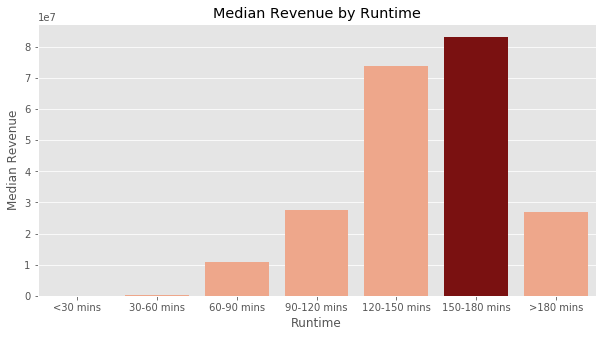

In [53]:
#bar chart comparing median revenue
x = ['<30 mins', '30-60 mins', '60-90 mins',
     '90-120 mins', '120-150 mins', '150-180 mins',
     '>180 mins']
y = [sub_30_median, sub_60_median, sub_90_median,
     sub_120_median, sub_150_median, sub_180_median,
     gt_180_median]
colors = ['lightsalmon' if (x < max(y)) else 'darkred' for x in y]

plt.figure(figsize=(10,5))
sns.barplot(x=x, y=y, palette=colors)
plt.title('Median Revenue by Runtime')
plt.xlabel('Runtime')
plt.ylabel("Median Revenue")

### Evaluate the Best Genres
Outline:
1. Import datasets
2. Fill missing IMDB IDs
3. Join imdb_title_basics df with revenue column from movies_df using imdb_id
4. Pull in averagerating column
5. Fill missing averagerating cells with the median
6. Split clean dataframe into 2 datasets, one to sum aggregate statistics, one to take the median
7. Create visualizations for the highest grossing genres and highest average rating genres

In [55]:
#read in datasets
imdb_name_basics = pd.read_csv('imdb.name.basics.csv')
imdb_title_basics = pd.read_csv('imdb.title.basics.csv')
imdb_title_crew = pd.read_csv('imdb.title.crew.csv')
imdb_title_ratings = pd.read_csv('imdb.title.ratings.csv')

In [56]:
#examine dataframe
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22521 entries, 0 to 22525
Data columns (total 21 columns):
adult                   22521 non-null object
budget                  22521 non-null float64
genres                  22521 non-null object
id                      22521 non-null float64
imdb_id                 19425 non-null object
original_language       22521 non-null object
original_title          22521 non-null object
overview                22521 non-null object
popularity              22521 non-null float64
production_companies    22521 non-null object
production_countries    22521 non-null object
release_date            22521 non-null object
revenue                 22521 non-null float64
runtime                 21932 non-null float64
spoken_languages        22521 non-null object
status                  22521 non-null object
tagline                 22521 non-null object
title                   22521 non-null object
video                   22521 non-null object
vote_average

In [57]:
#replace the missing imdb_id's with the string 'missing'
movies_df['imdb_id'].fillna('missing', inplace=True)

In [58]:
#set index to be the imdb_id
movies_df.set_index('imdb_id', inplace=True)

In [59]:
#check for duplicates
imdb_title_basics.index.duplicated().any()

False

In [60]:
#set imdb title basics index
imdb_title_basics.set_index('tconst', inplace=True)

In [61]:
#join revenue data from movies_df
genres_df = imdb_title_basics.join(movies_df['revenue'])

In [62]:
#set the index and pull in averagerating from imdb_title_ratings
imdb_title_ratings.set_index('tconst', inplace=True)
genres_df = genres_df.join(imdb_title_ratings['averagerating'])

In [63]:
#drop runtime column as we won't be using it
genres_df.drop(columns=['runtime_minutes'], inplace=True)

In [64]:
genres_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 146144 entries, tt0063540 to tt9916754
Data columns (total 6 columns):
primary_title     146144 non-null object
original_title    146123 non-null object
start_year        146144 non-null int64
genres            140736 non-null object
revenue           11493 non-null float64
averagerating     73856 non-null float64
dtypes: float64(2), int64(1), object(3)
memory usage: 12.8+ MB


In [65]:
#given amount of missing revenue data, we will drop NaN revenue amounts
genres_df = genres_df.dropna(subset=['revenue'])

In [66]:
#examine the df
genres_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11493 entries, tt0069049 to tt9916428
Data columns (total 6 columns):
primary_title     11493 non-null object
original_title    11493 non-null object
start_year        11493 non-null int64
genres            11425 non-null object
revenue           11493 non-null float64
averagerating     9931 non-null float64
dtypes: float64(2), int64(1), object(3)
memory usage: 628.5+ KB


In [67]:
#fill missing genres with string "NA" - missing genres may be significant so I don't want to remove them from the dataset
genres_df['genres'].fillna('NA', inplace=True)

In [68]:
genres_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11493 entries, tt0069049 to tt9916428
Data columns (total 6 columns):
primary_title     11493 non-null object
original_title    11493 non-null object
start_year        11493 non-null int64
genres            11493 non-null object
revenue           11493 non-null float64
averagerating     9931 non-null float64
dtypes: float64(2), int64(1), object(3)
memory usage: 628.5+ KB


In [69]:
#fill missing rating values with median
genres_df['averagerating'] = genres_df['averagerating'].fillna(genres_df['averagerating'].median())

In [70]:
genres_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11493 entries, tt0069049 to tt9916428
Data columns (total 6 columns):
primary_title     11493 non-null object
original_title    11493 non-null object
start_year        11493 non-null int64
genres            11493 non-null object
revenue           11493 non-null float64
averagerating     11493 non-null float64
dtypes: float64(2), int64(1), object(3)
memory usage: 628.5+ KB


Data is now clean with no missing data.  Group `genres_df` by genre and create aggregate statistics using the sum and the median

In [71]:
#group by genre and create 1 dataframe that shows the sum and one that shows median
genres_sum_df = genres_df.groupby('genres').sum()
genres_median_df = genres_df.groupby('genres').median()

In [72]:
#sort dataframes by revenue
genres_sum_df = genres_sum_df.sort_values('revenue', ascending=False)
genres_median_df = genres_median_df.sort_values('revenue', ascending=False)

Text(0, 0.5, 'Sum of Revenue')

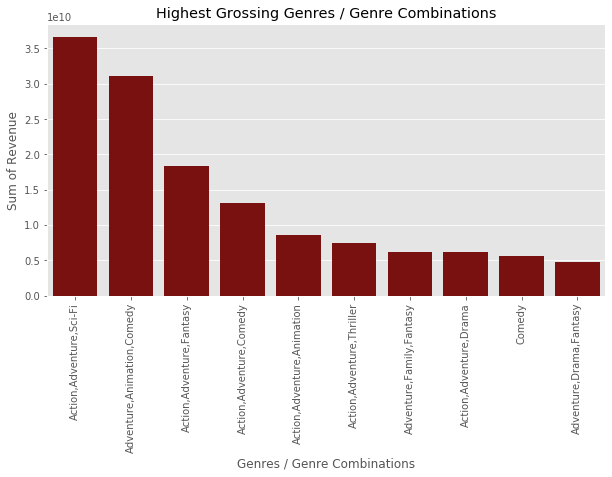

In [73]:
#create bar charts of top 10 revenue generating genres / combinations
fig = plt.figure(figsize=(10, 5))
colors = ['darkred' for i in range(10)]

sns.barplot(x=genres_sum_df.index[:10], 
            y='revenue', 
            data=genres_sum_df[:10],
            palette=colors)

plt.xticks(rotation=90)
plt.title('Highest Grossing Genres / Genre Combinations')
plt.xlabel('Genres / Genre Combinations')
plt.ylabel('Sum of Revenue')

We can see that over time, Action/Adventure/Sci-Fi has amassed the greatest revenue in aggregate, with Adventure/Animation/Comedy and Action/Adventure/Fantasy following.  While all time revenue as presented above is helpful, it does not say anything about how certain genres do in general.  To examine this, look at the highest median revenue movie genres.

Text(0, 0.5, 'Median Revenue')

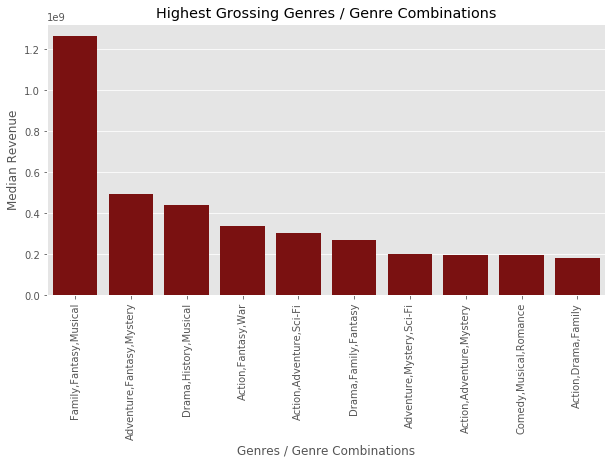

In [74]:
#create bar chart for median revenue
fig = plt.figure(figsize=(10, 5))
colors = ['darkred' for i in range(10)]

sns.barplot(x=genres_median_df.index[:10], 
            y='revenue', 
            data=genres_median_df[:10],
            palette=colors)

plt.xticks(rotation=90)
plt.title('Highest Grossing Genres / Genre Combinations')
plt.xlabel('Genres / Genre Combinations')
plt.ylabel('Median Revenue')

In [75]:
genres_median_df.head()

,start_year,revenue,averagerating
genres,,,
"Family,Fantasy,Musical",2017.0,1.263521e+09,7.2
"Adventure,Fantasy,Mystery",2012.0,4.944490e+08,6.5
"Drama,History,Musical",2012.0,4.418098e+08,7.6
"Action,Fantasy,War",2014.0,3.375801e+08,6.2
"Action,Adventure,Sci-Fi",2016.0,3.030255e+08,6.4


When looking at median revenue vs. all-time revenue we see Family/Fantasy/Musical movies tend to do best, and have significantly higher median revenue compared to other genres and genre combinations.  Median revenue related to Family/Fantasy/Musical movies is 1.3 billion compared to the next highest, Adventure/Fantasy/Mystery at ~$494 million

In [76]:
#sort dataframes by rating
genres_sum_df = genres_sum_df.sort_values('averagerating', ascending=False)
genres_median_df = genres_median_df.sort_values('averagerating', ascending=False)

Text(0, 0.5, 'Sum of IMDB Ratings')

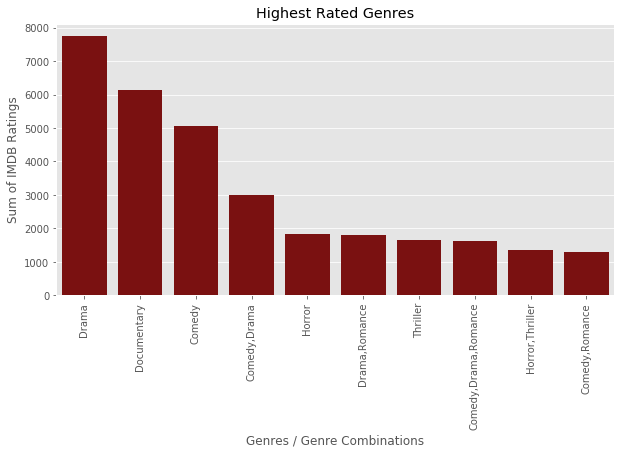

In [77]:
#create visualization for sum of ratings
fig = plt.figure(figsize=(10, 5))
colors = ['darkred' for i in range(10)]

sns.barplot(x=genres_sum_df.index[:10], 
            y='averagerating', 
            data=genres_sum_df[:10],
            palette=colors)

plt.xticks(rotation=90)
plt.title('Highest Rated Genres')
plt.xlabel('Genres / Genre Combinations')
plt.ylabel('Sum of IMDB Ratings')

When looking at sum of all ratings over time, we see that Drama, Documentary, and Comedy movies have been associated with highest ratings.  Similar to revenue, this shows aggregate information over time, but does not touch on how these movies tend to do in general.  Sum of ratings can be influenced by one very well performing movie in that genre, or more movies produced in that genre compared to others.

Text(0, 0.5, 'Median IMDB Rating')

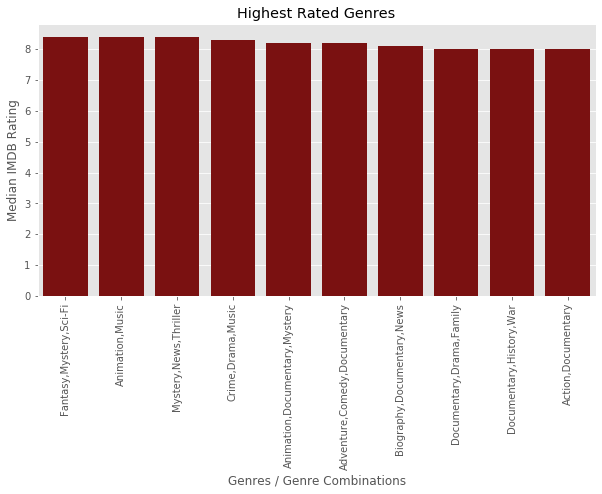

In [78]:
#create visualization for median of ratings
fig = plt.figure(figsize=(10, 5))
colors = ['darkred' for i in range(10)]

sns.barplot(x=genres_median_df.index[:10], 
            y='averagerating', 
            data=genres_median_df[:10],
            palette=colors)

plt.xticks(rotation=90)
plt.title('Highest Rated Genres')
plt.xlabel('Genres / Genre Combinations')
plt.ylabel('Median IMDB Rating')

When looking at median ratings, we still see that the combination of Comedy, Documentary, and Sports tends to do the best.  After Comedy/Documentary/Sports the median rating tends to fall off slightly, but remain close to or above a median average rating of 8.  

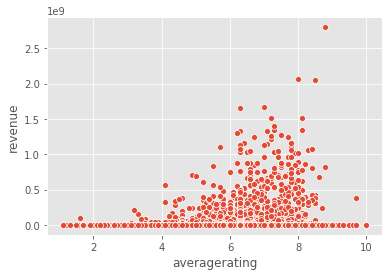

In [79]:
#evaluate the relationship between averagerating and revenue
sns.scatterplot(x='averagerating', y='revenue', data=genres_df)

In [80]:
#check the correlation between the 2
genres_df['averagerating'].corr(genres_df['revenue'])

0.11774814748539367

While average rating and revenue are slightly positively correlated as shown above, the relationship is not as linear as I would have thought.  Furthermore, there are differences between the highest grossing genres and the highest rated genres.  This should be taken into consideration when evaluating if revenue or ratings is more important to go-forward performance.

## Question 2: How has domestic movie spend trended over time, and when is the best time during the year to release a movie?

### Domestic Movie Spend
Outline:
1. Scrape boxofficemojo.com for domestic spend data by month and year
2. Create dataframe from scraped results
3. Look at summary statistics and distribution of gross domestic spend
4. Group data by years and sum domestic spend to show domestic spend trends over time
5. Create visualizations of annual domestic spend over time and monthly domestic spend over time
6. Analyze seasonality of gross domestic spend by looking at spend differences throughout the year over time and create visualizations

## Web Scrape to Pull Domestic Box Office Spend by Month

In [81]:
#Scrape box office mojo to get Domestic box office spend by month
from bs4 import BeautifulSoup
url = 'https://www.boxofficemojo.com/month/january/?grossesOption=calendarGrosses'
html_page = requests.get(url)
soup = BeautifulSoup(html_page.content, 'html.parser')

In [82]:
#create list of months to scrape
month_list = ['january', 'february', 'march', 'april', 'may',
              'june', 'july', 'august', 'september', 'october',
              'november', 'december']

#empty lists to store scraped data
months = []
years = []
gross_spend = []

#class used in scraping data
year_class = 'a-text-left mojo-header-column mojo-truncate mojo-field-type-year mojo-sort-column'

#loop through all months and scrape data for all years
for index, month in enumerate(month_list):
    url = f'https://www.boxofficemojo.com/month/{month}/?grossesOption=calendarGrosses'
    html_page = requests.get(url)
    soup = BeautifulSoup(html_page.content, 'html.parser')
    
    for td in soup.findAll('td', class_=year_class):
        years.append(td.text)
        months.append(month)
    
    for index, td in enumerate(soup.findAll('td', class_='a-text-right mojo-field-type-money')):
        if index%3 == 0:
            gross_spend.append(td.text[1:].replace(',', ''))
    
    #sleep to slow down scrape
    time.sleep(0.2)
    update_progress(index / (len(month_list)-1))

Progress: [####################] 100.0%


In [83]:
#check everything is the same size
print(len(months), len(years), len(gross_spend))

521 521 521


In [84]:
#create dataframe from scraped results
domestic_spend_df = pd.DataFrame([months, years, gross_spend]).transpose()
columns = ['month', 'year', 'gross_dom_spend']
domestic_spend_df.columns = columns

In [85]:
#examine dataframe
domestic_spend_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 521 entries, 0 to 520
Data columns (total 3 columns):
month              521 non-null object
year               521 non-null object
gross_dom_spend    521 non-null object
dtypes: object(3)
memory usage: 12.3+ KB


In [86]:
#convert spend column to int so they are easier to work with
domestic_spend_df['gross_dom_spend'] = domestic_spend_df['gross_dom_spend'].astype(int)

In [87]:
#check changes
domestic_spend_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 521 entries, 0 to 520
Data columns (total 3 columns):
month              521 non-null object
year               521 non-null object
gross_dom_spend    521 non-null int64
dtypes: int64(1), object(2)
memory usage: 12.3+ KB


Text(0.5, 1.0, 'Gross Domestic Distribution')

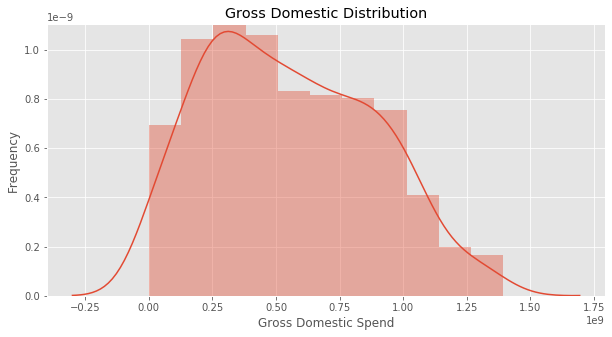

In [88]:
#look at distribution and summary stats for gross_dom_spend
plt.figure(figsize=(10, 5))
sns.distplot(domestic_spend_df['gross_dom_spend'])
plt.xlabel('Gross Domestic Spend')
plt.ylabel('Frequency')
plt.title('Gross Domestic Distribution')

In [89]:
domestic_spend_df.describe()

,gross_dom_spend
count,5.210000e+02
mean,5.529929e+08
std,3.306034e+08
min,5.201500e+04
25%,2.719556e+08
50%,5.110006e+08
75%,8.128497e+08
max,1.394221e+09


Gross domestic spend has a slight bimodal distribution with a slight positive skew.  75% of monthly gross domestic spend data falls under 813 million, with the median at 511 million, and a standard deviation of 330 million

In [90]:
#convert month and year columns to ints 
conversion_dict = {'january': 1, 'february': 2, 'march': 3, 'april': 4, 'may': 5,
                   'june': 6, 'july': 7, 'august': 8, 'september': 9, 'october': 10,
                   'november': 11, 'december': 12}
domestic_spend_df['month'] = domestic_spend_df['month'].apply(lambda x: conversion_dict[x])

In [91]:
domestic_spend_df['year'] = domestic_spend_df['year'].astype(int)

In [92]:
#group_df by year to show cumulative spend stats over time by year using sum
year_df = domestic_spend_df.groupby('year', as_index=False).sum()
year_df.head()

,year,month,gross_dom_spend
0,1972,15,218262039
1,1975,24,260000000
2,1976,25,113537424
3,1977,68,443497461
4,1978,46,826413013


Text(0.5, 0, 'Year')

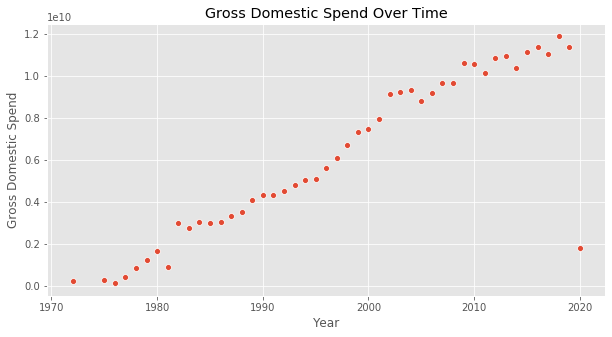

In [93]:
#scatter plot of gross_dom_spend over time
plt.figure(figsize=(10, 5))
sns.scatterplot(x='year', y='gross_dom_spend', data=year_df)
plt.title('Gross Domestic Spend Over Time')
plt.ylabel('Gross Domestic Spend')
plt.xlabel('Year')

Gross Domestic Spend has shown consistent growth since the 1970s through today.  2020 datapoint only contains partial year data, so appears lower than other years

In [94]:
#convert month and year back to strings to convert to datetime
domestic_spend_df['month'] = domestic_spend_df['month'].astype(str)
domestic_spend_df['year'] = domestic_spend_df['year'].astype(str)

In [95]:
domestic_spend_df.head()

,month,year,gross_dom_spend
0,1,2020,897742569
1,1,2019,812849718
2,1,2018,958572920
3,1,2017,958541647
4,1,2016,1035615039


In [96]:
#create date column that will be converted to datetime
domestic_spend_df['date'] = domestic_spend_df['year'] + '-' + domestic_spend_df['month'] + '-1'


In [97]:
#check that it worked
domestic_spend_df.head()

,month,year,gross_dom_spend,date
0,1,2020,897742569,2020-1-1
1,1,2019,812849718,2019-1-1
2,1,2018,958572920,2018-1-1
3,1,2017,958541647,2017-1-1
4,1,2016,1035615039,2016-1-1


In [98]:
#convert date column to datetime object
import datetime as dt
domestic_spend_df['date'] = domestic_spend_df['date'].apply(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

In [99]:
#look at info
domestic_spend_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 521 entries, 0 to 520
Data columns (total 4 columns):
month              521 non-null object
year               521 non-null object
gross_dom_spend    521 non-null int64
date               521 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 16.4+ KB


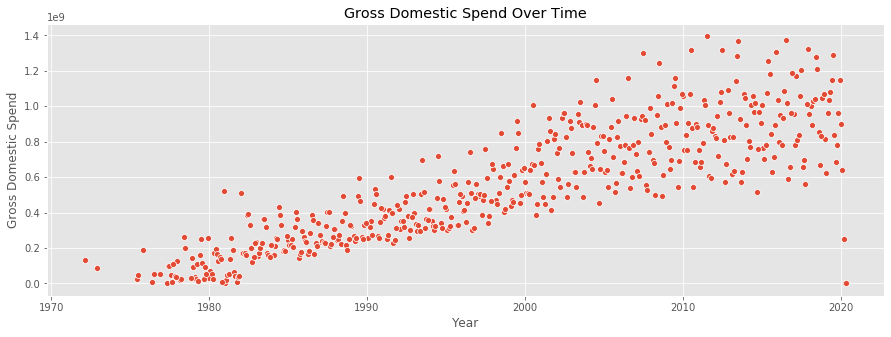

In [100]:
#create a graph showing gross domestic spend over time
#add register_matplotlib_converters() to silence warnings
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters() 

plt.figure(figsize=(15, 5))
ax = sns.scatterplot(x='date', y='gross_dom_spend', data=domestic_spend_df)
plt.title('Gross Domestic Spend Over Time')
plt.xlabel('Year')
plt.ylabel('Gross Domestic Spend')
plt.show()


As shown above in the visualization of annual gross domestic spend over time, we see a similar pattern with monthly gross domestic spend over time.  Monthly gross domestic spend appears to have more variability the closer you get to 2020.

In [101]:
#convert month to int to evaluate seasonality
domestic_spend_df['month'] = domestic_spend_df['month'].astype(int)
domestic_spend_df['year'] = domestic_spend_df['year'].astype(int)

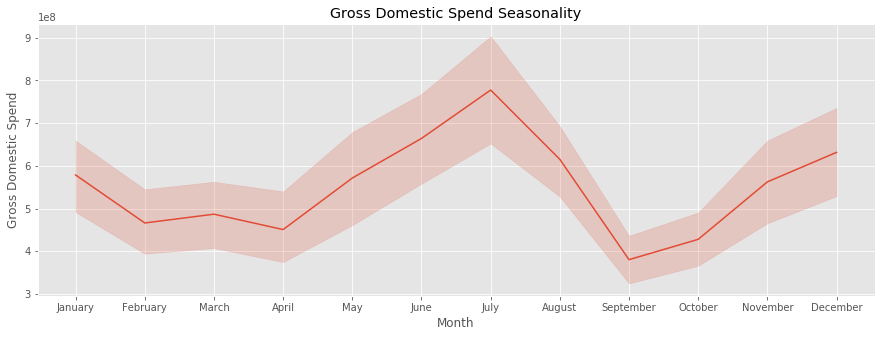

In [102]:
#create a line graph with error bars showing seasonality of movies
plt.figure(figsize=(15, 5))
xticks = np.arange(1,13)
sns.lineplot(x='month', y='gross_dom_spend', data=domestic_spend_df)
plt.title('Gross Domestic Spend Seasonality')
xlabels = ['January', 'February', 'March', 'April', 
           'May', 'June', 'July', 'August', 'September', 
           'October', 'November', 'December']
plt.xticks(ticks=xticks, labels=xlabels)
plt.xlabel('Month')
plt.ylabel('Gross Domestic Spend')
plt.show()

There are clear peaks in gross domestic produce in the summer months, with a smaller peak also occurring in the winter months.  While summer months tend to prodcue the highest median gross domestic spend, the variability and error bars around these months also appears highest

Text(0, 0.5, 'Gross Domestic Spend')

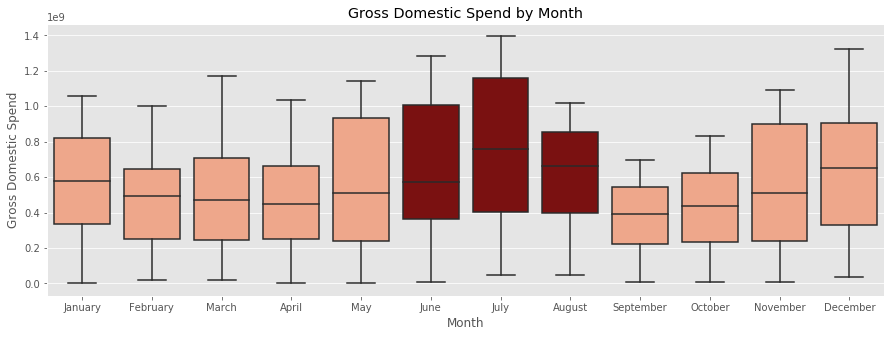

In [103]:
#plot boxplots for each month to show distributions
plt.figure(figsize=(15, 5))
colors = ['lightsalmon' if (x < 5) |  (x > 7) else 'darkred' for x in range(12)]

sns.boxplot(x='month', y='gross_dom_spend', data=domestic_spend_df, palette=colors)
xticks = np.arange(12)
xlabels = ['January', 'February', 'March', 'April', 
           'May', 'June', 'July', 'August', 'September', 
           'October', 'November', 'December']

plt.xticks(ticks=xticks, labels=xlabels)
plt.title('Gross Domestic Spend by Month')
plt.xlabel('Month')
plt.ylabel('Gross Domestic Spend')

In [104]:
domestic_spend_df.loc[domestic_spend_df['month'] == 7].std()

month              0.000000e+00
year               1.313393e+01
gross_dom_spend    4.201236e+08
dtype: float64

In [105]:
domestic_spend_df.loc[domestic_spend_df['month'] == 2].std()

month              0.000000e+00
year               1.255654e+01
gross_dom_spend    2.533268e+08
dtype: float64

While the summer months tend to coincide with higher domestic spend, the variance also tends to be higher.  As an example, standard deviation for the month of July is 420 million compared to ~250 million in February.  Targeting movie release in the fall or spring will generally coincide with lower gross domestic spend, but it will vary less and be more closely distributed to the median.

## Question 3: Which writers should be hired to produce the highest grossing movies?

#### Movie Writer Analysis
Outline:
1. Import necessary datasets
2. Movies can contain multiple writers, so in these cases, convert writers cell to a list and split each writer onto their own row
3. Join imdb_name_basics to pull in writer names
4. Create df from movies_df containing IMDB ID and revenue
5. Group by imdb_id and join with writers df
6. Group by writer and evaluate highest revenue writers
7. Produce visualizations

In [106]:
#import crew dataset
imdb_title_crew = pd.read_csv('imdb.title.crew.csv')
imdb_title_crew.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146144 entries, 0 to 146143
Data columns (total 3 columns):
tconst       146144 non-null object
directors    140417 non-null object
writers      110261 non-null object
dtypes: object(3)
memory usage: 3.3+ MB


In [107]:
#examine the crew dataset
imdb_title_crew.head()

,tconst,directors,writers
0,tt0285252,nm0899854,nm0899854
1,tt0438973,NaN,"nm0175726,nm1802864"
2,tt0462036,nm1940585,nm1940585
3,tt0835418,nm0151540,"nm0310087,nm0841532"
4,tt0878654,"nm0089502,nm2291498,nm2292011",nm0284943


In [108]:
#as shown, the data lists multiple writers in the same cell
#split the writers rows into a list of writers
imdb_title_crew['writers_list'] = imdb_title_crew['writers'].apply(lambda x: str(x).split(','))

In [109]:
#check that it worked
imdb_title_crew.head()

,tconst,directors,writers,writers_list
0,tt0285252,nm0899854,nm0899854,[nm0899854]
1,tt0438973,NaN,"nm0175726,nm1802864","[nm0175726, nm1802864]"
2,tt0462036,nm1940585,nm1940585,[nm1940585]
3,tt0835418,nm0151540,"nm0310087,nm0841532","[nm0310087, nm0841532]"
4,tt0878654,"nm0089502,nm2291498,nm2292011",nm0284943,[nm0284943]


In [110]:
#looking for total writer attribution, so for movies with multiple
#writers, split them onto their own rows
list_col = 'writers_list'
movie_ids = np.repeat(imdb_title_crew['tconst'].values,
                      imdb_title_crew[list_col].str.len())

In [111]:
writers_ids = np.concatenate(imdb_title_crew[list_col].values)

In [112]:
len(movie_ids)

214235

In [113]:
len(writers_ids)

214235

In [114]:
#create dataframes and join relevant columns
writers = pd.DataFrame(writers_ids)
movies = pd.DataFrame(movie_ids)

In [115]:
writers = writers.join(movies, how='outer', rsuffix='_tmdb')

In [116]:
writers.columns = ['writerID', 'imdb_id']

In [117]:
writers.head()

,writerID,imdb_id
0,nm0899854,tt0285252
1,nm0175726,tt0438973
2,nm1802864,tt0438973
3,nm1940585,tt0462036
4,nm0310087,tt0835418


In [118]:
imdb_name_basics = pd.read_csv('imdb.name.basics.csv')
imdb_name_basics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 606648 entries, 0 to 606647
Data columns (total 6 columns):
nconst                606648 non-null object
primary_name          606648 non-null object
birth_year            82736 non-null float64
death_year            6783 non-null float64
primary_profession    555308 non-null object
known_for_titles      576444 non-null object
dtypes: float64(2), object(4)
memory usage: 27.8+ MB


In [119]:
#join primary_name into writers_df
imdb_name_basics.set_index('nconst', inplace=True)
writers.set_index('writerID', inplace=True)

In [120]:
imdb_name_basics = imdb_name_basics.join(writers)

In [121]:
#reset index
movies_df.reset_index(inplace=True)

In [122]:
#pull revenue and imdb_id out of movies_df
small_movies_df = movies_df[['imdb_id', 'revenue']]

In [123]:
small_movies_df

,imdb_id,revenue
0,tt2935510,132807427.0
1,tt1634106,24573617.0
2,tt3152592,0.0
3,tt8851668,0.0
4,tt10303324,0.0
...,...,...
22516,tt11290110,0.0
22517,tt12222000,0.0
22518,missing,0.0
22519,missing,0.0


In [124]:
#check for na in imdb_id column
small_movies_df['imdb_id'].isna().sum()

0

In [125]:
#group by imdb_id and sum revenue
small_movies_df = small_movies_df.groupby('imdb_id').sum()

In [126]:
imdb_name_basics.set_index('imdb_id', inplace=True)

In [127]:
#join revenue detail from small_movies_df
writer_details_df = imdb_name_basics.join(small_movies_df)

In [128]:
writer_details_df.head()

,primary_name,birth_year,death_year,primary_profession,known_for_titles,revenue
imdb_id,,,,,,
tt0063540,Abrar Alvi,1927.0,2009.0,"writer,actor,director","tt0071811,tt0359496,tt0056436,tt0061046",NaN
tt0063540,Gulzar,1936.0,NaN,"music_department,writer,soundtrack","tt0091256,tt0178186,tt1010048,tt2176013",NaN
tt0063540,Mahasweta Devi,1926.0,2016.0,writer,"tt0108001,tt0832902,tt0063540,tt0178562",NaN
tt0063540,Anjana Rawail,NaN,NaN,"writer,costume_designer","tt0293499,tt0266712,tt0266757,tt0063540",NaN
tt0069049,Orson Welles,1915.0,1985.0,"actor,director,writer","tt0048393,tt0052311,tt0057427,tt0033467",0.0


In [129]:
#reset index
writer_details_df.reset_index(inplace=True)

In [130]:
#group by writer name and produce aggregate statistics for the median
grouped_writers = writer_details_df.groupby('primary_name').median()

In [131]:
grouped_writers['revenue'].value_counts()

0.0            11376
117224271.0       23
32438988.0        18
7171.0            16
81170000.0        13
               ...  
19102646.0         1
74668.5            1
306162232.0        1
19145732.0         1
66110186.0         1
Name: revenue, Length: 2769, dtype: int64

In [132]:
grouped_writers.reset_index(inplace=True)

In [133]:
#sort by revenue
grouped_writers = grouped_writers.sort_values('revenue', ascending=False)

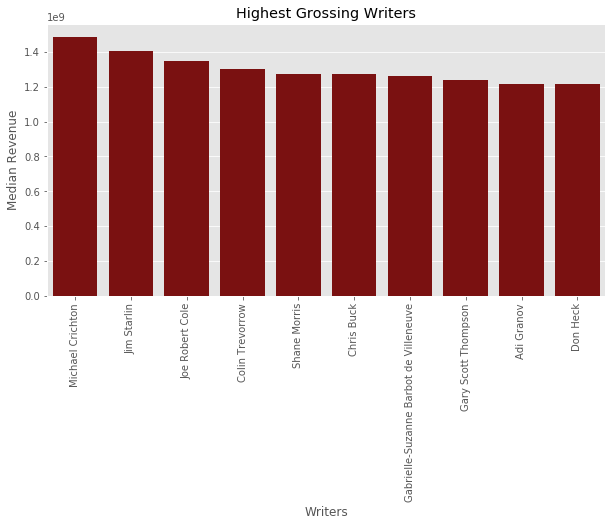

In [134]:
#create bar chart of top writers
fig=plt.figure(figsize=(10, 5))
colors = ['darkred' for i in range(10)]

sns.barplot(x=grouped_writers['primary_name'][:10],
            y='revenue', 
            data=grouped_writers[:10],
            palette=colors)

plt.xticks(rotation=90)
plt.title('Highest Grossing Writers')
plt.xlabel('Writers')
plt.ylabel('Median Revenue')
plt.show()

Michael Crichton and Jim Starlin produce the highest median revenue movies.  These two writers should be targeted if possible, but others within the top 10 are not bad choices either.  All writers in the top 10 are associated with median movie revenue generation of $1.2 billion. I would recommend targeting one of these top writers who is familiar with one of the top genres identified earlier. 